# Inference Tasks on Stellar Spectra to Stellar Parameters

In [1]:
import pylab as plt
import numpy as np
import pandas as pd
from astropy.io import fits
from astroNN.shared.matplotlib import pylab_style
from mygaiadb.spec import yield_xp_coeffs
from utils.gaia_utils import mag_to_flux
from utils.plotting_utils import top_cbar
from astropy.stats import mad_std

import torch
from stellarperceptron.model import StellarPerceptron

pylab_style(paper=True)
rng = np.random.default_rng(0)

# ================== hardware-related settings ==================
device = "cuda:0"  # "cpu" for CPU or "cuda:x" for a NVIDIA GPU
mixed_precision = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
# ================== hardware-related settings ==================

nn_model = StellarPerceptron.load(
    "./model_torch/", mixed_precision=mixed_precision, device=device
)
andae2023_f = fits.getdata("./andae2023_catalog/table_2_catwise.fits.gz")

# andae2023_f_random_idx = np.random.uniform(0, 1000, size=len(andae2023_f))
andae2023_f_good_idx = (
    (andae2023_f["ruwe"] < 1.4)
    & (andae2023_f["phot_g_mean_mag"] < 16.0)
    & (andae2023_f["phot_g_mean_mag"] > 6.0)
    & (andae2023_f["phot_bp_mean_mag"] - andae2023_f["phot_rp_mean_mag"] < 4.0)
    & (andae2023_f["phot_bp_mean_mag"] - andae2023_f["phot_rp_mean_mag"] > 0.0)
)

nn_teff = np.ones(len(andae2023_f[andae2023_f_good_idx])) * np.nan
nn_teff_err = np.ones(len(andae2023_f[andae2023_f_good_idx])) * np.nan
nn_logg = np.ones(len(andae2023_f[andae2023_f_good_idx])) * np.nan
nn_logg_err = np.ones(len(andae2023_f[andae2023_f_good_idx])) * np.nan
nn_m_h = np.ones(len(andae2023_f[andae2023_f_good_idx])) * np.nan
nn_m_h_err = np.ones(len(andae2023_f[andae2023_f_good_idx])) * np.nan

obs_names = [
    *[f"bp{i}" for i in range(32)],
    *[f"rp{i}" for i in range(32)],
]

gaia_g_apperent_flux = mag_to_flux(andae2023_f["phot_g_mean_mag"])

for i in yield_xp_coeffs(andae2023_f["source_id"][andae2023_f_good_idx]):
    coeffs, idx = i
    coeffs = np.hstack([coeffs[:, :32], coeffs[:, 55:87]])
    coeffs /= np.expand_dims(gaia_g_apperent_flux[andae2023_f_good_idx][idx], axis=-1)
    nn_model.perceive(
        coeffs,
        obs_names,
    )
    pred_df = nn_model.request(["teff", "logg", "m_h"])
    nn_teff[idx] = pred_df["teff"].values
    nn_teff_err[idx] = pred_df["teff_error"].values
    nn_logg[idx] = pred_df["logg"].values
    nn_logg_err[idx] = pred_df["logg_error"].values
    nn_m_h[idx] = pred_df["m_h"].values
    nn_m_h_err[idx] = pred_df["m_h_error"].values
    nn_model.clear_perception()

100%|██████████| 3386/3386 [20:45<00:00,  2.72it/s]


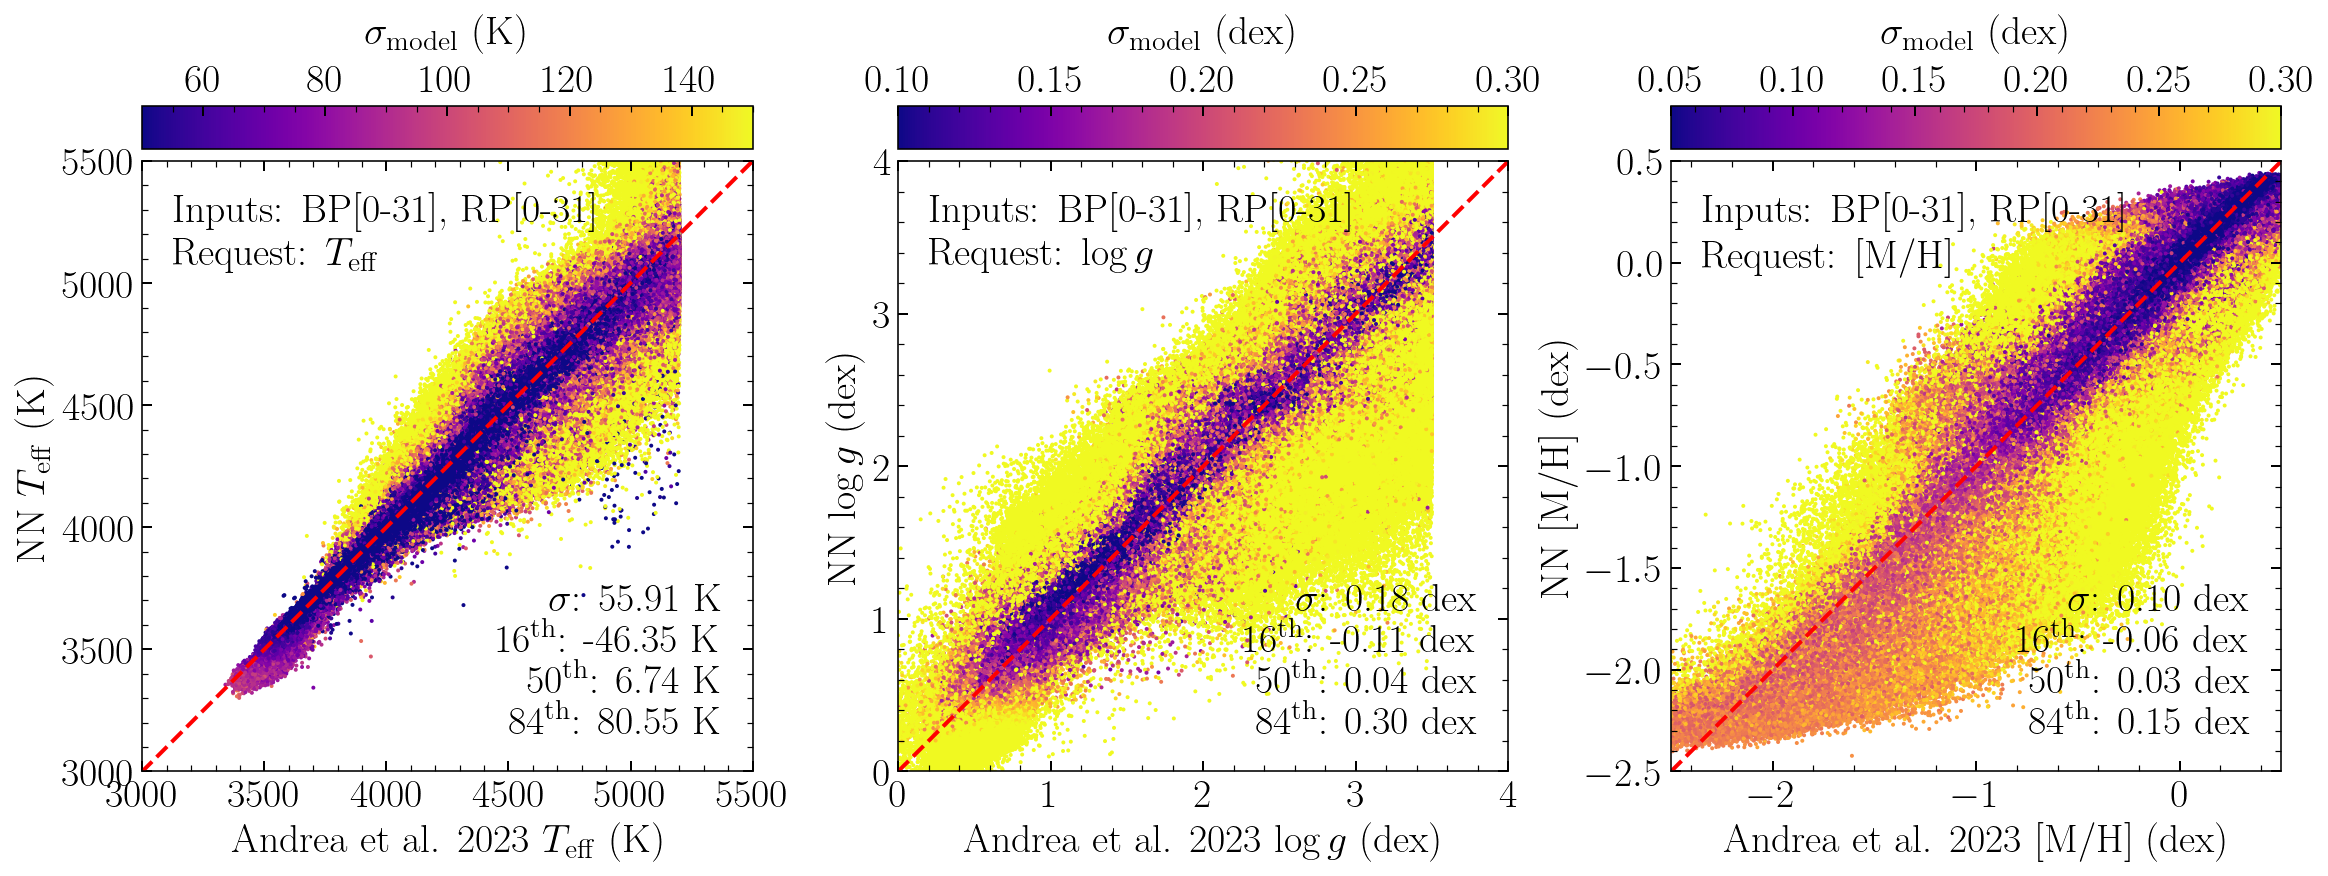

In [21]:
good_idx = (nn_teff_err < 500) & (nn_logg_err < 0.5) & (nn_m_h_err < 0.5)

fig = plt.figure(figsize=(20, 6.0))
subfigs = fig.subfigures(1, 1)
(ax1, ax2, ax3) = subfigs.subplots(
    1, 3, gridspec_kw={"wspace": 0.1, "hspace": 0.1, "width_ratios": [1, 1, 1.05]}
)

mappable = ax1.scatter(
    andae2023_f["teff_xgboost"][andae2023_f_good_idx][good_idx],
    nn_teff[good_idx],
    s=1,
    c=nn_teff_err[good_idx],
    vmin=50,
    vmax=150,
    cmap="plasma",
    rasterized=True,
)
ax1.plot([0, 10000], [0, 10000], c="r", ls="--", lw=2)
ax1.set_xlim(3000, 5500)
ax1.set_ylim(3000, 5500)
ax1.set_xlabel("Andrea et al. 2023 $T_\mathrm{eff}$ (K)")
ax1.set_ylabel("NN $T_\mathrm{eff}$ (K)")
teff_diff = (
    andae2023_f["teff_xgboost"][andae2023_f_good_idx][good_idx] - nn_teff[good_idx]
)
ax1.annotate(
    "Inputs: BP[0-31], RP[0-31]\nRequest: $T_\mathrm{eff}$",
    xy=(0.05, 0.95),
    xycoords=ax1,
    fontsize=20,
    ha="left",
    va="top",
)
ax1.annotate(
    f"$\sigma$: {mad_std(teff_diff):.2f} K\n"
    + f"$16^\mathrm{{th}}$: {np.percentile(teff_diff, 16):.2f} K\n"
    + f"$50^\mathrm{{th}}$: {np.percentile(teff_diff, 50):.2f} K\n"
    + f"$84^\mathrm{{th}}$: {np.percentile(teff_diff, 84):.2f} K",
    xy=(0.95, 0.05),
    xycoords=ax1,
    fontsize=20,
    ha="right",
    va="bottom",
)
ax1.set_aspect("equal", "box")
top_cbar(ax1, mappable, "$\sigma_\mathrm{model}$ (K)", labelpad=10)

mappable = ax2.scatter(
    andae2023_f["logg_xgboost"][andae2023_f_good_idx][good_idx],
    nn_logg[good_idx],
    s=1,
    c=nn_logg_err[good_idx],
    vmin=0.1,
    vmax=0.3,
    cmap="plasma",
    rasterized=True,
)
ax2.plot([0.0, 4.0], [0.0, 4.0], c="r", ls="--", lw=2)
ax2.set_xlim(0.0, 4.0)
ax2.set_ylim(0.0, 4.0)
ax2.set_xlabel("Andrea et al. 2023 $\log{g}$ (dex)")
ax2.set_ylabel("NN $\log{g}$ (dex)")
ax2.annotate(
    "Inputs: BP[0-31], RP[0-31]\nRequest: $\log{g}$",
    xy=(0.05, 0.95),
    xycoords=ax2,
    fontsize=20,
    ha="left",
    va="top",
)
logg_diff = (
    andae2023_f["logg_xgboost"][andae2023_f_good_idx][good_idx] - nn_logg[good_idx]
)
ax2.annotate(
    f"$\sigma$: {mad_std(logg_diff):.2f} dex\n"
    + f"$16^\mathrm{{th}}$: {np.percentile(logg_diff, 16):.2f} dex\n"
    + f"$50^\mathrm{{th}}$: {np.percentile(logg_diff, 50):.2f} dex\n"
    + f"$84^\mathrm{{th}}$: {np.percentile(logg_diff, 84):.2f} dex",
    xy=(0.95, 0.05),
    xycoords=ax2,
    fontsize=20,
    ha="right",
    va="bottom",
)
ax2.set_aspect("equal", "box")
top_cbar(ax2, mappable, "$\sigma_\mathrm{model}$ (dex)", labelpad=10)

mappable = ax3.scatter(
    andae2023_f["mh_xgboost"][andae2023_f_good_idx][good_idx],
    nn_m_h[good_idx],
    s=1,
    c=nn_m_h_err[good_idx],
    vmin=0.05,
    vmax=0.3,
    cmap="plasma",
    rasterized=True,
)
ax3.plot([-2.5, 0.5], [-2.5, 0.5], c="r", ls="--", lw=2)
ax3.set_xlim(-2.5, 0.5)
ax3.set_ylim(-2.5, 0.5)
ax3.set_xlabel("Andrea et al. 2023 [M/H] (dex)")
ax3.set_ylabel("NN [M/H] (dex)")
ax3.annotate(
    "Inputs: BP[0-31], RP[0-31]\nRequest: [M/H]",
    xy=(0.05, 0.95),
    xycoords=ax3,
    fontsize=20,
    ha="left",
    va="top",
)
mh_diff = andae2023_f["mh_xgboost"][andae2023_f_good_idx][good_idx] - nn_m_h[good_idx]
ax3.annotate(
    f"$\sigma$: {mad_std(mh_diff):.2f} dex\n"
    + f"$16^\mathrm{{th}}$: {np.percentile(mh_diff, 16):.2f} dex\n"
    + f"$50^\mathrm{{th}}$: {np.percentile(mh_diff, 50):.2f} dex\n"
    + f"$84^\mathrm{{th}}$: {np.percentile(mh_diff, 84):.2f} dex",
    xy=(0.95, 0.05),
    xycoords=ax3,
    fontsize=20,
    ha="right",
    va="bottom",
)
ax3.set_aspect("equal", "box")
top_cbar(ax3, mappable, "$\sigma_\mathrm{model}$ (dex)", labelpad=10)

fig.savefig("./figs/andrae_compare.pdf", bbox_inches="tight", dpi=200)